# Unity Cloud Simulation and Automated Playtest with Amazon SageMaker RL

---
## Introduction

[Unity](https://unity.com/) is currently the most popular gaming engine used by game developers around the world. Unity engine can be used to create 3D, 2D, virtual reality, and augmented reality games, as well as simulations and other experiences. [ML-Agents](https://github.com/Unity-Technologies/ml-agents) is an open-sourced toolkit developed by Unity to enable games and simulations to serve as environments for training intelligent agents. It provides capabilities on how to interact with Unity executables as well as how to train a RL agent. For how to use ML-Agents to train a Unity game agent on SageMaker, please refer to this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/unity_ml_agents/unity_mlagents_learn.ipynb).

This sample notebook walks you through how to train the RL agents and automate playtests against a Unity game by using cloud simulation with Amazon SageMaker RL. Once you create your new game with Unity, you can automate playtests for your game by running the RL agent on Amazon SageMaker RL. After the playtests, you can also evaluate and visualize the result from game logs.

## Bring your own custom Unity environment

For this sample, you can use your custom Unity executable for training.
1. [Create a Unity executable](https://github.com/Unity-Technologies/ml-agents/blob/742c2fbf01188fbf27e82d5a7d9b5fd42f0de67a/docs/Learning-Environment-Executable.md) of your environment for Linux. Please make sure your environment only contains one single agent.
2. Upload the executable file, dependency data files and library files to s3.
3. Specify the s3 path in the form of `S3://<your bucket name>/<prefix>` in the following variable. 
ex) `s3_binary_path = 's3://unity-environment-1113/RollerBall'` 
It is used later for the training job and the evaluation step.

In [388]:
s3_binary_path = 's3://sagemaker-unity-mlagents/RollerBall'

## Pre-requisites

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [389]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [390]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-unity-mlagents/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [391]:
# create a descriptive job name 
job_name_prefix = 'rl-unity-ray'

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [392]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.c5.2xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [393]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::730547285608:role/SageMakerHandson


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [394]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Build docker container

We must build a custom docker container with Roboschool installed.  This takes care of everything:

1. Fetching base container image
2. Installing Roboschool and its dependencies
3. Uploading the new container image to ECR

This step can take a long time if you are running on a machine with a slow internet connection.  If your notebook instance is in SageMaker or EC2 it should take 3-10 minutes depending on the instance type.


In [395]:
%%time

cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-unity-ray-%s" % cpu_or_gpu
docker_build_args = {
    'CPU_OR_GPU': cpu_or_gpu, 
    'AWS_REGION': boto3.Session().region_name,
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store
Logged into ECR
Building docker image sagemaker-unity-ray-cpu from Dockerfile
$ docker build -t sagemaker-unity-ray-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=ap-northeast-1
Sending build context to Docker daemon  1.258MB
Step 1/12 : ARG CPU_OR_GPU
Step 2/12 : ARG AWS_REGION
Step 3/12 : FROM 462105765813.dkr.ecr.${AWS_REGION}.amazonaws.com/sagemaker-rl-ray-container:ray-0.8.2-tf-${CPU_OR_GPU}-py36
 ---> 38b6fd16b6b3
Step 4/12 : WORKDIR /opt/ml
 ---> Using cache
 ---> 6849c7cf3565
Step 5/12 : RUN apt-get update &&     apt-get install -y libboost-python-dev
 ---> Using cache
 ---> dab5dd63bbd8
Step 6/12 : RUN apt-get update     && apt-get install -y --no-install-recomm

## Write the Training Code

The training code is written in the file “train-unity.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function.


In [396]:
!pygmentize src/train-unity.py

import json
import os
import subprocess

import gym
import ray
from ray.tune import run_experiments
from ray.tune.registry import register_env

from sagemaker_rl.ray_launcher import SageMakerRayLauncher
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.registry import default_registry
from gym_unity.envs import UnityToGymWrapper


class UnityEnvWrapper(gym.Env):
    def __init__(self, env_config):
        self.worker_index = env_config.worker_index

        if 'SM_CHANNEL_TRAIN' in os.environ:
            env_name = os.environ['SM_CHANNEL_TRAIN'] +'/'+ env_config['env_name']
            subprocess.call(f'chmod 755 {env_name}'.split())
            unity_env = UnityEnvironment(
                      env_name, 
                      no_graphics=True, 
                      worker_id=self.worker_index, 
                      additional_args=['-logFile', 'unity.log'])
        else:
            env_name = env_config['env_name']
            unity_env = default_registry

## Train the RL model using the Python SDK Script mode with Unity executables

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [401]:
%%time

metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)
    
estimator = RLEstimator(entry_point="train-unity.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        hyperparameters={
                          # Attention scientists!  You can override any Ray algorithm parameter here:
                          "rl.training.config.env_config.env_name": "RollerBallSimulation.x86_64",
                          "rl.training.stop.timesteps_total": 40000,
                          #"rl.training.config.train_batch_size": 100,
                          #"rl.training.config.num_sgd_iter": 10,
                        }
                    )

estimator.fit({'train': s3_binary_path}, wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: rl-unity-ray-2020-11-13-05-07-55-303
CPU times: user 107 ms, sys: 6.64 ms, total: 114 ms
Wall time: 593 ms


## Visualization
### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

Training job started. Waiting for algorithm metric...


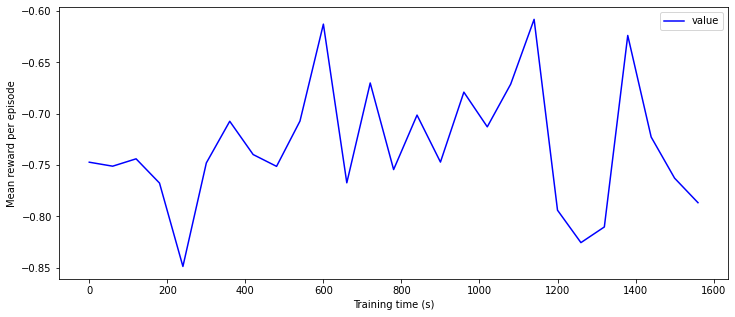

In [404]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics
import time

sm_client = boto3.client(service_name='sagemaker')
state = sm_client.describe_training_job(
    TrainingJobName=job_name).get('SecondaryStatus')

if not local_mode:
    while state == 'Starting':
        state = sm_client.describe_training_job(
            TrainingJobName=job_name).get('SecondaryStatus')
        print("Training job starting...")
        time.sleep(30)
    print("Training job started. Waiting for algorithm metric...")
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    num_metrics = len(df)
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch, please check later.")
    else:
        plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
        plt.set_ylabel('Mean reward per episode')
        plt.set_xlabel('Training time (s)')
else:
    print("Can't plot metrics in local mode.")

## Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

### Load checkpointed model for evaluation

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [405]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

if local_mode:
    model_tar_key = "{}/model.tar.gz".format(job_name)
else:
    model_tar_key = "{}/output/model.tar.gz".format(job_name)
    
local_checkpoint_dir = "{}/model".format(tmp_dir)

wait_for_s3_object(s3_bucket, model_tar_key, tmp_dir, training_job_name=job_name)  

if not os.path.isfile("{}/model.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File model.tar.gz not found")
    
os.system("mkdir -p {}".format(local_checkpoint_dir))
os.system("tar -xvzf {}/model.tar.gz -C {}".format(tmp_dir, local_checkpoint_dir))

print("Checkpoint directory {}".format(local_checkpoint_dir))

Create local folder /tmp/rl-unity-ray-2020-11-13-05-07-55-303
Waiting for s3://sagemaker-unity-mlagents/rl-unity-ray-2020-11-13-05-07-55-303/output/model.tar.gz...
Checkpoint directory /tmp/rl-unity-ray-2020-11-13-05-07-55-303/model


In [406]:
if local_mode:
    checkpoint_path = 'file://{}'.format(local_checkpoint_dir)
    print("Local checkpoint file path: {}".format(local_checkpoint_dir))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(local_checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(local_checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://sagemaker-unity-mlagents/rl-unity-ray-2020-11-13-05-07-55-303/checkpoint/


In [412]:
!pygmentize src/evaluate-unity.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import json
import os
import subprocess
import shutil
from glob import glob

import numpy as np
import os

import gym
from gym import wrappers
import ray
from ray.rllib.models import ModelCatalog
from ray.tune.registry import register_env
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.environment_parameters_channel import EnvironmentParametersChannel
from mlagents_envs.exception import UnityWorkerInUseException
from mlagents_envs.registry import default_registry
from gym_unity.envs import UnityToGymWrapper


OUTPUT_DIR = "/opt/ml/output/intermediate"


class UnityEnvWrapper(gym.Env):
    def __init__(self, env_config):
        self.worker_index = 0

        if 'SM_CHANNEL_TRAIN' in os.environ:
            env_name = os.environ['SM_CHANNEL_TRAIN'] +'/'+ env_config['env_name']
            os.chmod(env_name, 0o755)
          

### Run the evaluation step for a Unity environment using the trained RL model

Use the checkpointed model to run the evaluation step.

In [431]:
%%time
    
estimator_eval = RLEstimator(entry_point="evaluate-unity.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix + "-evaluation",
                        hyperparameters={
                            "evaluate_episodes": 1200,
                            "algorithm": "PPO",
                            "env": "RollerBallSimulation.x86_64"
                        }
                    )

estimator_eval.fit({'model': checkpoint_path, 'train': s3_binary_path}, wait=local_mode) # specify a train channel for the custom Unity executable option
job_name = estimator_eval.latest_training_job.job_name

CPU times: user 101 ms, sys: 4.6 ms, total: 105 ms
Wall time: 545 ms


## Visualize the output for the stage evaluation

In [429]:
tmp_dir = "/tmp/{}".format(job_name)
summary_logs_dir = "{}/Logs".format(tmp_dir)
os.system("mkdir -p {}".format(summary_logs_dir))
print("Create local directory for Summary Logs {}".format(summary_logs_dir))

if local_mode:
    summary_log_key = "{}/intermediate/Logs".format(job_name)
else:
    summary_log_key = "{}/output/intermediate/Logs".format(job_name)

wait_for_s3_object(s3_bucket, summary_log_key, summary_logs_dir, training_job_name=job_name)  

if not os.path.isdir(summary_logs_dir):
    raise FileNotFoundError("Directory Logs not found")

Create local directory for Summary Logs /tmp/rl-unity-ray-evaluation-2020-11-18-07-53-58-756/Logs
Waiting for s3://sagemaker-unity-mlagents/rl-unity-ray-evaluation-2020-11-18-07-53-58-756/output/intermediate/Logs...


/tmp/rl-unity-ray-evaluation-2020-11-18-07-53-58-756/Logs/20201118_075742RollerBallSummaryLog.csv
10844


,number_of_obstacles,cleared?,status
0,9,False,2
1,11,False,2
2,11,False,2
3,7,False,2
4,3,False,3
...,...,...,...
150,1,False,3
151,5,False,2
152,5,False,2
153,1,False,2


,number_of_obstacles,success_rate,total_count
5,1,0.107143,28
3,3,0.333333,21
4,5,0.266667,30
2,7,0.160000,25
0,9,0.068966,29
1,11,0.136364,22


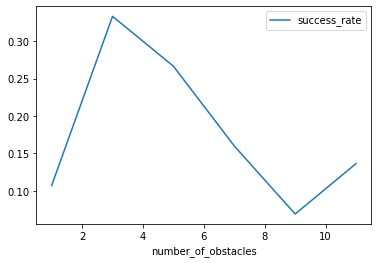

In [430]:
%matplotlib inline
from glob import glob
import pandas as pd
files = glob("{}/*.csv".format(summary_logs_dir), recursive=True)
for file in files:
    print(file)
    print(os.path.getsize(file))
    result = pd.read_csv(file)
    display(result.drop(['play_id', 'message', 'created_at'], axis=1))
    number_of_obstacles = result['number_of_obstacles'].unique()
    summary = []
    for item in number_of_obstacles:
        cleared_count = ((result['number_of_obstacles'] == item) & (result['cleared?'] == True)).sum()
        total_count = (result['number_of_obstacles'] == item).sum()
        success_rate = cleared_count / total_count
        summary.append([item, success_rate, total_count])
    if len(summary) != 0:
        df = pd.DataFrame(summary, columns=['number_of_obstacles', 'success_rate', 'total_count']).sort_values('number_of_obstacles')
        display(df)
        df=df.astype(float)
        df.plot(x='number_of_obstacles', y='success_rate')